# Deep inside: Autoencoders

This notebook is the complement of [this blog post](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)

4 types of autoencoders are described using the Keras framework and the MNIST dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder

## Import the libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


## Load the data

We don't need the labels as the autoencoders are unsupervised network

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [3]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten the images for the Fully-Connected Networks

In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

___

# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [5]:
input_size = 784
hidden_size = 64
output_size = 784

In [6]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
import pydot as pyd
keras.utils.vis_utils.pydot = pyd

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [ ]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

In [ ]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predict on the test set

In [19]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [22]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [ ]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Convolutional autoencoder**

In [ ]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

### Create the network

This network does not take flattened vectors as an input but images

In [ ]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [ ]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Regularized autoencoder**

Two types of regularization are described : 
- Sparse autoencoder
- Denoising autoencoder

## 1. Sparse autoencoder

### Create the network

In [ ]:
input_size = 784
hidden_size = 32
output_size = 784

In [ ]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [ ]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

In [5]:
### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 2. Denoising autoencoder

In [9]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

### Create noisy data

In [10]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Create the network

In [6]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

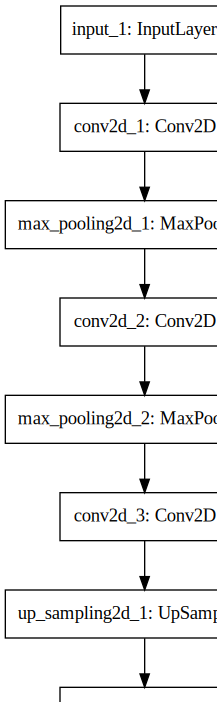

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [12]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1755 - val_loss: 0.1245
Epoch 2/3
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1194 - val_loss: 0.1115
Epoch 3/3
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1118 - val_loss: 0.1080


In [13]:
decoded_imgs = autoencoder.predict(X_test_noisy)

### Plot

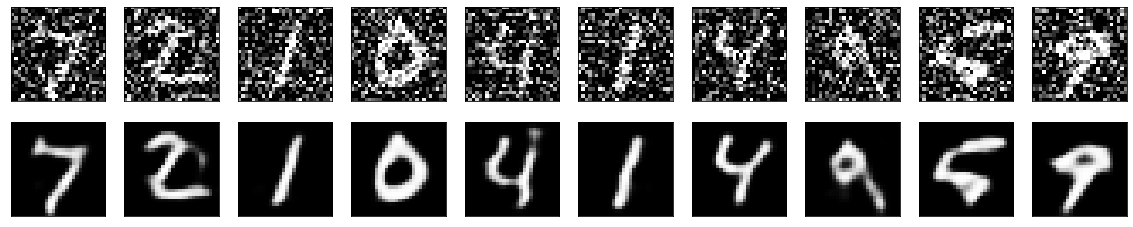

In [14]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['val_loss', 'loss'])


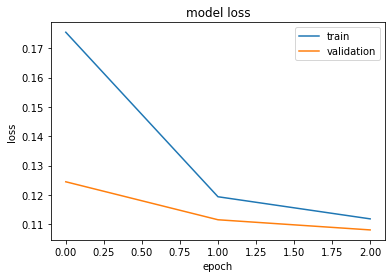

In [15]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

---